# Modelling challenge: Predicting loan defaults


The goal of this exercise is to find which model performs the best on this dataset.

This dataset consisted of around 50,000 loans and 101 attributes. 

One of the attributes is a default indicator that says whether the loan has defaulted or not.

The code below goes through 3 main steps:

1 - Clean, transform, complete the data

2 - Select the modeling algorithm

3 - Assess the model quality

The code is commented and results are explained.

In [1]:
# we import libraries that will be needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

## 1. Read in the dataset and do basic checks

In [2]:
loans_df = pd.read_csv('modeling_challenge_data_2017.12.27.csv')
loans_df.describe()

,loanNumber,monthOriginated,default,var1,var2,var4,var5,var6,var7,var8,...,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98
count,52918.000000,52918.000000,52918.000000,52918.000000,52619.000000,5.291800e+04,51879.000000,52174.000000,52139.000000,52918.000000,...,52918.000000,52918.000000,52918.000000,5.261900e+04,52619.000000,5.187900e+04,5.187900e+04,51879.000000,5.187900e+04,5.187900e+04
mean,26459.500000,201446.631449,0.091198,0.005480,4.618731,8.144960e+04,15329.111240,9164.297945,66.485729,0.009467,...,46.454477,0.047054,27.204713,5.776432e+04,23441.117752,4.718874e+04,3.584723e+04,178.984194,1.661558e+05,2.003850e+05
std,15276.255109,88.982428,0.287893,0.077814,3.076202,6.350256e+04,15747.599221,13505.183972,26.427349,0.108614,...,41.849424,0.333253,11.768903,4.994096e+04,20910.281548,4.483767e+04,3.282418e+04,1993.890078,1.570253e+05,1.721624e+05
min,1.000000,201201.000000,0.000000,0.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,...,-10.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.000000e+02
25%,13230.250000,201405.000000,0.000000,0.000000,2.000000,5.289825e+04,4292.000000,1280.250000,48.200000,0.000000,...,7.000000,0.000000,19.000000,2.829600e+04,9600.000000,1.865300e+04,1.730000e+04,0.000000,4.460750e+04,6.896850e+04
50%,26459.500000,201502.000000,0.000000,0.000000,4.000000,7.000000e+04,10637.000000,4263.000000,71.700000,0.000000,...,30.000000,0.000000,26.000000,4.561500e+04,17500.000000,3.695300e+04,2.810000e+04,0.000000,1.276040e+05,1.598000e+05
75%,39688.750000,201508.000000,0.000000,0.000000,6.000000,9.589700e+04,21224.500000,11249.500000,89.300000,0.000000,...,100.000000,0.000000,34.000000,7.148200e+04,30900.000000,6.309350e+04,4.470000e+04,0.000000,2.423505e+05,2.842935e+05
max,52918.000000,201602.000000,1.000000,3.000000,40.000000,8.700000e+06,368681.000000,205543.000000,151.400000,6.000000,...,100.000000,15.000000,126.000000,2.652799e+06,834300.000000,1.269783e+06,1.641300e+06,296368.000000,4.127799e+06,4.392634e+06


We process the date variables, so that we can use them in our model.

In [3]:
# some variables are dates:
# monthOriginated, and var14

# set the date column to be the date
loans_df['var14'] = pd.to_datetime(loans_df['var14'])

def date_covert(dstring):
    dt_date = dt.datetime.strptime(str(dstring) + '01', '%Y%m%d')
    return dt_date

loans_df['monthOriginated'] = loans_df['monthOriginated'].apply(date_covert)

def date_month(dt_date):
    return dt_date.month

def date_year(dt_date):
    return dt_date.year

def date_day(dt_date):
    return dt_date.day

#translate these date values into numbers, so that the machine learning models can work with them

loans_df['Orig_month'] = loans_df['monthOriginated'].apply(date_month)
loans_df['Orig_year'] = loans_df['monthOriginated'].apply(date_year)

loans_df['var14_day'] = loans_df['var14'].apply(date_day)
loans_df['var14_month'] = loans_df['var14'].apply(date_month)
loans_df['var14_year'] = loans_df['var14'].apply(date_year)

# var3 looks like State
# we can assume that variables with only 1 and 0 values are only "True" or "False",
# but except for the variable "default", we don't know what they mean
# all other variables are numerical
# it's hard to tell if some of the negative values should be dropped, 
# because we don't know what are they supposed to be encoding

In [4]:
loans_df.describe()

,loanNumber,default,var1,var2,var4,var5,var6,var7,var8,var9,...,var94,var95,var96,var97,var98,Orig_month,Orig_year,var14_day,var14_month,var14_year
count,52918.000000,52918.000000,52918.000000,52619.000000,5.291800e+04,51879.000000,52174.000000,52139.000000,52918.000000,52918.000000,...,5.187900e+04,5.187900e+04,51879.000000,5.187900e+04,5.187900e+04,52918.000000,52918.000000,52918.0,52918.000000,52918.000000
mean,26459.500000,0.091198,0.005480,4.618731,8.144960e+04,15329.111240,9164.297945,66.485729,0.009467,0.013625,...,4.718874e+04,3.584723e+04,178.984194,1.661558e+05,2.003850e+05,6.805680,2014.398258,1.0,6.709135,1997.317642
std,15276.255109,0.287893,0.077814,3.076202,6.350256e+04,15747.599221,13505.183972,26.427349,0.108614,0.128161,...,4.483767e+04,3.282418e+04,1993.890078,1.570253e+05,1.721624e+05,3.488582,0.895653,0.0,3.386876,7.126903
min,1.000000,0.000000,0.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.000000e+02,1.000000,2012.000000,1.0,1.000000,1944.000000
25%,13230.250000,0.000000,0.000000,2.000000,5.289825e+04,4292.000000,1280.250000,48.200000,0.000000,0.000000,...,1.865300e+04,1.730000e+04,0.000000,4.460750e+04,6.896850e+04,4.000000,2014.000000,1.0,4.000000,1994.000000
50%,26459.500000,0.000000,0.000000,4.000000,7.000000e+04,10637.000000,4263.000000,71.700000,0.000000,0.000000,...,3.695300e+04,2.810000e+04,0.000000,1.276040e+05,1.598000e+05,7.000000,2015.000000,1.0,7.000000,1999.000000
75%,39688.750000,0.000000,0.000000,6.000000,9.589700e+04,21224.500000,11249.500000,89.300000,0.000000,0.000000,...,6.309350e+04,4.470000e+04,0.000000,2.423505e+05,2.842935e+05,10.000000,2015.000000,1.0,10.000000,2002.000000
max,52918.000000,1.000000,3.000000,40.000000,8.700000e+06,368681.000000,205543.000000,151.400000,6.000000,4.000000,...,1.269783e+06,1.641300e+06,296368.000000,4.127799e+06,4.392634e+06,12.000000,2016.000000,1.0,12.000000,2012.000000


As we can see, some data is missing.

For now, for missing values, we fill the missing values in the given column with an average for the given column.
We remove the values where this operation wouldn't make sense (for example, date variables, or state variable).

In [5]:
columns_names = list(loans_df.columns.values)

columns_names.remove('monthOriginated')
columns_names.remove('default')
columns_names.remove('var3')
columns_names.remove('var14')
columns_names.remove('loanNumber')


for col in columns_names:
    loans_df[col] = loans_df[col].fillna(loans_df[col].mean(), axis = 0)

loans_df.describe()


loans_df['loanNumber'] = loans_df.index

In this model that we are constructing, the variable 'Default' will be the dependent variable. Our model will be treating the other variables as independent variables.

For that reason, we want to check if some variables are correlated already.

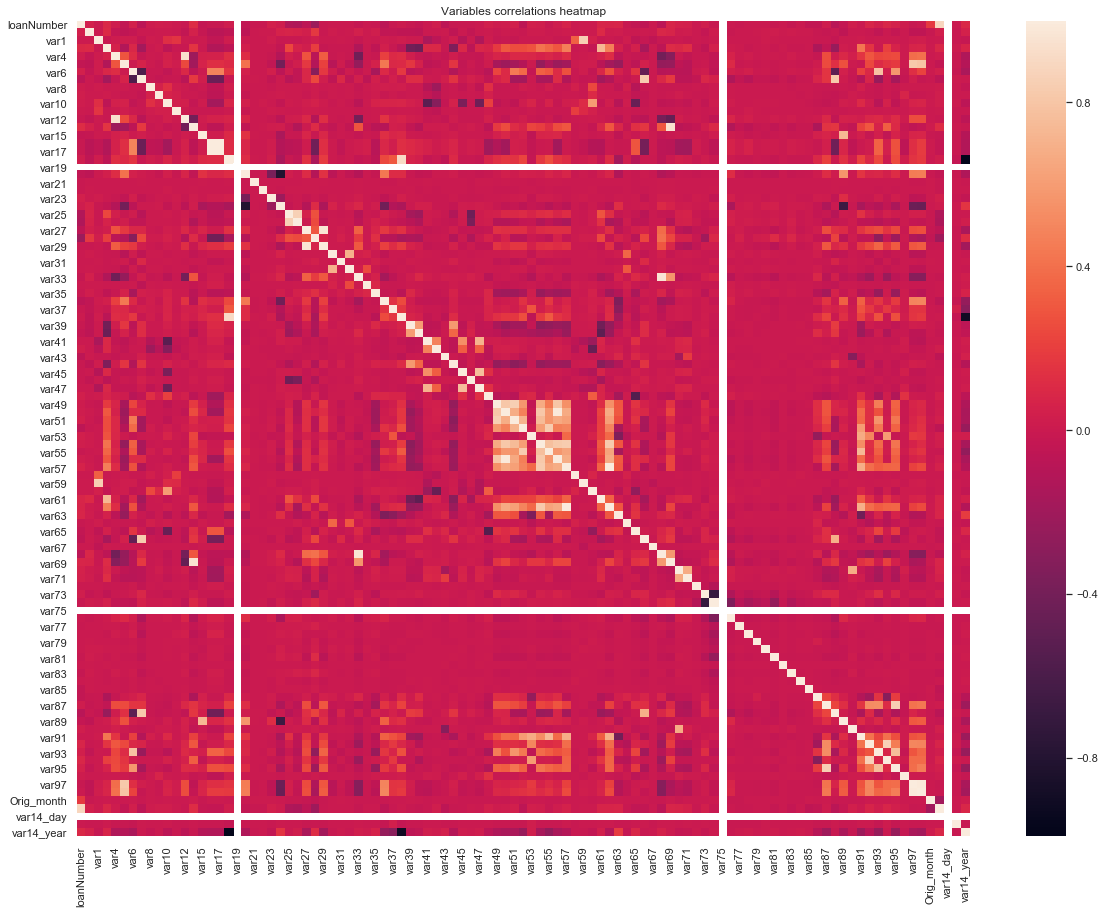

In [6]:
# plot a heatmap to see if the variables are not somewhat correlated

import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib.pyplot as plt 

plt.figure(figsize = (20, 15))

# also, get a csv to see if there is something obviously wrong with the data and correlations
loans_df.to_csv('loans_num_data.csv')

correls = loans_df.corr()
correls.to_csv('correls.csv')

sns.heatmap(loans_df.corr()).set_title('Variables correlations heatmap')

plt.show()


It turns out that some variables can be dropped:

- var14_day is always 1, so it won't help us
- var19, var75 are always 0, so they also won't help us with predicting the loan default


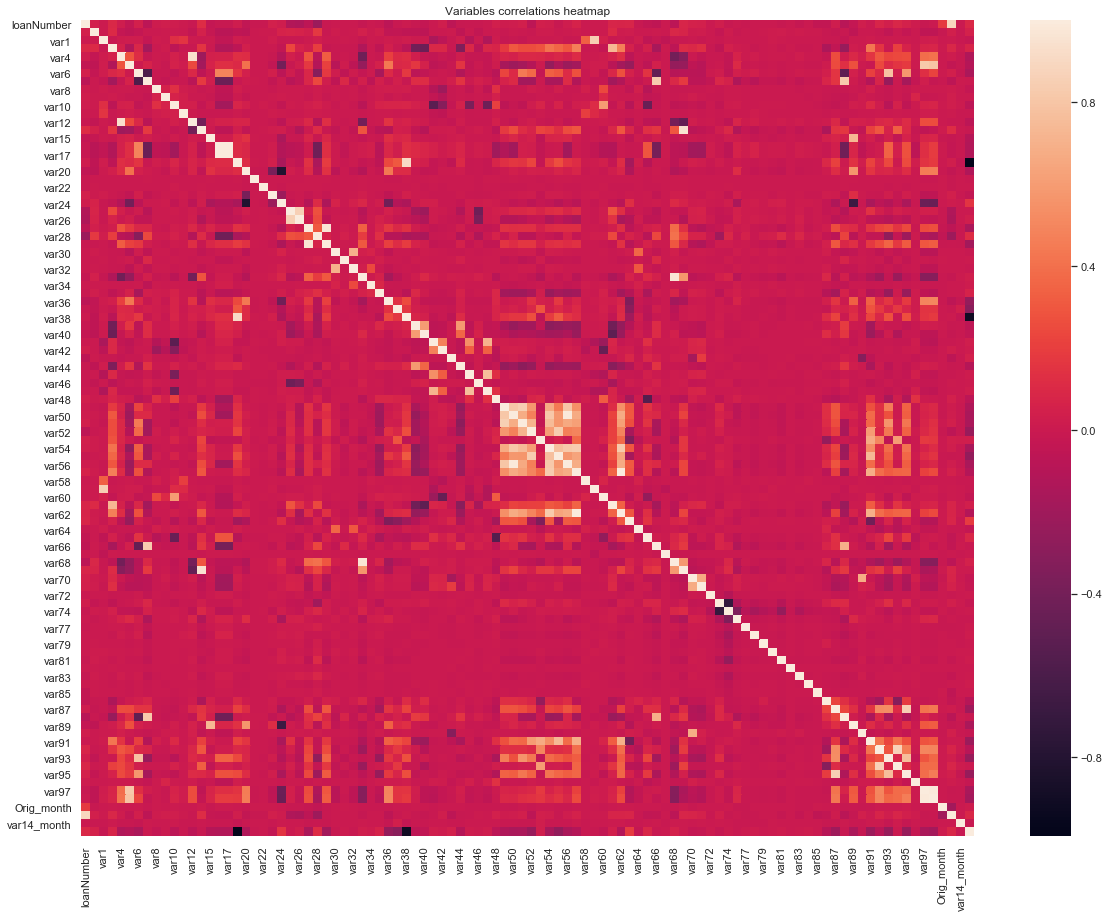

In [7]:
loans_df.drop(['var14_day', 'var19', 'var75'], inplace=True, axis=1, errors = 'ignore')

# we also drop the columns that can't be used in calculating correlations, because they are not numeric
loans_df.drop(['monthOriginated', 'var3','var14' ], inplace=True, axis=1, errors = 'ignore')


plt.figure(figsize = (20, 15))


correls = loans_df.corr()
correls.to_csv('correls.csv')

sns.heatmap(loans_df.corr()).set_title('Variables correlations heatmap')

plt.show()


Some of the correlations can be explained already, and some variables can be dropped:
- loanNumber and orig_year are highly correlated, because loan numbers increase as time passes. The identifier shouldn't have an impact on whether or not the borrower defaults, but the time when the loan was underwritten could have an impact. So, we will drop loanNumber.
- var16 is highly correlated with var17: var17 seems to be the value in var16, but rounded to the nearest integer less or equal to var16 divisible by 5. Therefore, var17 can be dropped.
- var38 is highly correlated with var18; the values are close, but var18 has more data present. So, var38 can be dropped.
- same for var59 and var1: therefore, var59 can be dropped.

In [11]:
loans_df.drop(['var17', 'loanNumber', 'var38', 'var59'], inplace=True, axis=1, errors = 'ignore')

In [12]:
# check Variance Inflation Factors (VIF) among the variables used in this regression

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


X = add_constant(loans_df)
vif_results = pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
              index=X.columns)
vif_results.to_csv('cp_test_vif_results.csv')

-c:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


The Variance Inflation Factor (VIF) test tests for possible multicollinearity of the factors used in the model.
For variables where VIF is high, this is an indication that they don't need to be used in the model.

##  2. Find which model performs the best

We will first try simpler models that are easy to understand. Then, we will experiment with more complex models, and see if they perform better.

## Logistic Regression

In [13]:
loans_df.describe()

,default,var1,var2,var4,var5,var6,var7,var8,var9,var10,...,var93,var94,var95,var96,var97,var98,Orig_month,Orig_year,var14_month,var14_year
count,52918.000000,52918.000000,52918.000000,5.291800e+04,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,...,52918.000000,5.291800e+04,5.291800e+04,52918.000000,5.291800e+04,5.291800e+04,52918.000000,52918.000000,52918.000000,52918.000000
mean,0.091198,0.005480,4.618731,8.144960e+04,15329.111240,9164.297945,66.485729,0.009467,0.013625,0.321535,...,23441.117752,4.718874e+04,3.584723e+04,178.984194,1.661558e+05,2.003850e+05,6.805680,2014.398258,6.709135,1997.317642
std,0.287893,0.077814,3.067498,6.350256e+04,15592.234521,13409.908116,26.232107,0.108614,0.128161,0.864653,...,20851.122572,4.439531e+04,3.250034e+04,1974.218499,1.554761e+05,1.704638e+05,3.488582,0.895653,3.386876,7.126903
min,0.000000,0.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.000000e+02,1.000000,2012.000000,1.000000,1944.000000
25%,0.000000,0.000000,2.000000,5.289825e+04,4371.250000,1310.000000,48.600000,0.000000,0.000000,0.000000,...,9700.000000,1.904425e+04,1.750000e+04,0.000000,4.541850e+04,7.003175e+04,4.000000,2014.000000,4.000000,1994.000000
50%,0.000000,0.000000,4.000000,7.000000e+04,11017.500000,4395.000000,71.100000,0.000000,0.000000,0.000000,...,17600.000000,3.775350e+04,2.860000e+04,0.000000,1.322505e+05,1.644850e+05,7.000000,2015.000000,7.000000,1999.000000
75%,0.000000,0.000000,6.000000,9.589700e+04,20970.750000,11078.000000,89.000000,0.000000,0.000000,0.000000,...,30800.000000,6.232900e+04,4.420000e+04,0.000000,2.398220e+05,2.812265e+05,10.000000,2015.000000,10.000000,2002.000000
max,1.000000,3.000000,40.000000,8.700000e+06,368681.000000,205543.000000,151.400000,6.000000,4.000000,26.000000,...,834300.000000,1.269783e+06,1.641300e+06,296368.000000,4.127799e+06,4.392634e+06,12.000000,2016.000000,12.000000,2012.000000


In [14]:
from sklearn import linear_model

# select just the corresponding data for logistic regression

# we will drop the columns that won't help us

loan_outcome = loans_df['default']
loan_parameters = loans_df.loc[:, loans_df.columns != 'default']

# see how does the model perform

n_samples = len(loan_outcome)
threshold = int(.9*n_samples)
print(threshold)

# we train on the first 90% of the sample size,
# and use 10 % for testing the model performance
X_train = loan_parameters[:threshold]
y_train = loan_outcome[:threshold]
X_test = loan_parameters[threshold:]
y_test = loan_outcome[threshold:]

logistic = linear_model.LogisticRegression(max_iter=7600)

print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

#look at coefficients with the highest value
results_df = pd.DataFrame(
    {'parameter': loan_parameters.columns,
     'coefficient': logistic.coef_[0,:]
    })

results_df['coef_abs'] = results_df['coefficient'].abs()

print('Variables with highest importance (top 10): ')

results_df = results_df.sort_values(by=['coef_abs'], ascending=False)
print(results_df[:10])

47626


/Users/ninakuklisova/miniconda2/envs/jupi_modern/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression score: 0.859788
Variables with highest importance (top 10): 
    coefficient parameter  coef_abs
22     0.006537     var27  0.006537
38    -0.001729     var44  0.001729
13    -0.001698     var16  0.001698
81    -0.001392     var89  0.001392
14    -0.001245     var18  0.001245
32    -0.000892     var37  0.000892
33    -0.000854     var39  0.000854
34    -0.000513     var40  0.000513
25     0.000463     var30  0.000463
10    -0.000450     var12  0.000450


So, according to logistic regression, these are the most important variables in this model.

Let's try another model and see if we can get predictions that will be more accurate.

## Decision Tree 

In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

In [16]:
dt_e = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)

dt_e.fit(X_train, y_train)

print 'Accuracy (a decision tree with information gain used for measuring the quality of the split):', dt_e.score(X_test, y_test)

dt_g = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=0)

dt_g.fit(X_train, y_train)

print 'Accuracy (a decision tree with Gini impurity used for measuring the quality of the split):', dt_g.score(X_test, y_test)



Accuracy (a decision tree with information gain used for measuring the quality of the split): 0.7976190476190477
Accuracy (a decision tree with Gini impurity used for measuring the quality of the split): 0.7883597883597884


The Decision Tree model didn't outperform Logistic Resgression. This might be due to overfitting that can sometimes happen for decision trees.

## Random Forest 

Since the performance of Decision Trees didn't outperform Logistic Regression, we shall try more advanced methods.
Because Decision Trees sometimes overfit to the data that was available and then perform poorly on test data,
we can try Random Forests to prevent this problem.
We can try the Random Forests with different number of estimators.

In [18]:
rfc_100 = RandomForestClassifier(n_estimators=100)
#rfc.fit(train_data, train_labels)
rfc_100.fit(X_train, y_train)

print 'Accuracy (a random forest with 100 estimators):', rfc_100.score(X_test, y_test)

rfc_90 = RandomForestClassifier(n_estimators=90)
#rfc.fit(train_data, train_labels)
rfc_90.fit(X_train, y_train)

print 'Accuracy (a random forest with 90 estimators):', rfc_90.score(X_test, y_test)

rfc_95 = RandomForestClassifier(n_estimators=95)
#rfc.fit(train_data, train_labels)
rfc_95.fit(X_train, y_train)

print 'Accuracy (a random forest with 95 estimators):', rfc_95.score(X_test, y_test)

Accuracy (a random forest with 100 estimators): 0.859599395313681
Accuracy (a random forest with 90 estimators): 0.8592214663643235
Accuracy (a random forest with 95 estimators): 0.859599395313681


So, we see we get a different accuracy of predictions depending on the number of estimators.
Let's see what is the optimal number.

The code below will run a more complete search.

In [30]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = RandomForestClassifier()

params = {
    "n_estimators": [80, 90, 100],
    "max_depth": [5,8,15],
    "min_samples_leaf" : [1, 2, 4]
}

clf = GridSearchCV(gridsearch_forest, param_grid=params, n_jobs=-1, cv=3 )
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [80, 90, 100], 'max_depth': [5, 8, 15], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 80}

In [32]:
clf.best_score_

0.9142905135850166

In [33]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## AdaBoost 

We see that a tree bagging method can perform pretty well.

We can try also some boosting methods. Let's start with the AdaBoost.

In [34]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=109, learning_rate=0.1)

abc.fit(X_train, y_train)
print 'Accuracy (adaboost with decision trees):', abc.score(X_test, y_test)

Accuracy (adaboost with decision trees): 0.8573318216175358


This didn't outperform the random forest. Let's try another boosting method.

## Gradient Boost

It will be interesting to compare the accuracy of Gradient Boosting with the previous methods.

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=109, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

print 'Accuracy (Gradient Boost):', clf.score(X_test, y_test)                 

Accuracy (Gradient Boost): 0.8597883597883598


Again, here is another Grid Search that could help us increase accuracy.

In [36]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = GradientBoostingClassifier()

params = {
    "n_estimators": [80, 100, 120],
    "max_depth": [1, 2, 3],
    "min_samples_leaf" : [1, 2, 4]
}

clf = GridSearchCV(gridsearch_forest, param_grid=params, n_jobs=-1, cv=3 )
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [80, 100, 120], 'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
clf.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 80}

In [38]:
clf.best_score_

0.9140805442405409

## 3. Conclusions

Based on this analysis, we found that the best performing model is Random Forest, with accuracy 91.42%, and 80 estimators.

After that, the second best performing model is Gradient Boosting, with accuracy 91.41%, and 80 estimators.

After that, the third best performing model is Logistic Regression.
It has accuracy score 85.98%,
and the most important variables are
var27, var44, var16, var89, var18.
A significant advantage of this model is that it allows us to clearly see relations between the key variables.